<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/ML-Manuel/RF%26LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreProcessing

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

In [113]:
!git clone -b ML-Manuel https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 529, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 529 (delta 90), reused 27 (delta 25), pack-reused 385 (from 1)
Receiving objects: 100% (529/529), 61.72 MiB | 22.76 MiB/s, done.
Resolving deltas: 100% (275/275), done.
/content/DATCapstone/data/DATCapstone/data/DATCapstone/data/DATCapstone/data/DATCapstone/data


In [114]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [115]:


df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_763,emb_764,emb_765,emb_766,emb_767,Target_1day,Target_1week,Target_1month,Target_1year,Ticker
149,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,NaN,NaN,NaN,NaN,NaN,1.128571,1.756653,10.863785,9.008606,AAPL
152,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,-3.444626,0.245331,7.016815,0.616699,AAPL
155,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,1.933334,3.601639,9.637100,-0.162491,AAPL
158,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,0.873398,0.392532,8.744034,2.098389,AAPL
161,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,1.265976,-1.069687,9.313263,4.827057,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8062,2025-01-27,394.799988,406.690002,389.000000,397.149994,58125500,0.0,0.0,29723.864,4.0,...,1.174326,-0.262426,0.298183,0.182200,0.388200,0.940002,NaN,NaN,NaN,TSLA
8072,2025-01-28,396.910004,400.589996,386.500000,398.089996,48910700,0.0,0.0,29723.864,4.0,...,0.084330,-0.354550,-0.611864,-0.449780,0.584349,-8.989990,NaN,NaN,NaN,TSLA
8082,2025-01-29,395.209991,398.589996,384.480011,389.100006,68033600,0.0,0.0,29723.864,4.0,...,0.827862,-0.620100,-0.024186,-0.439615,0.781107,11.179993,NaN,NaN,NaN,TSLA
8092,2025-01-30,410.779999,412.500000,384.410004,400.279999,98092900,0.0,0.0,29723.864,4.0,...,1.383147,-0.616897,-0.145329,-0.418483,0.636253,4.320007,NaN,NaN,NaN,TSLA


In [116]:
#Read Data
# df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data.csv', index_col=0)
# Correct path for ZIP file
zip_path = '/content/DATCapstone/data/_data.csv.zip'

# Extract specific file from ZIP
with ZipFile(zip_path, 'r') as z:
    with z.open('data.csv') as f:  # Explicitly specify the file to extract
        df = pd.read_csv(f, index_col=0)


df['Date'] = pd.to_datetime(df['Date'])

#Forward fill -> micro, macro, stock / fill na -> sentiment
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df = df.dropna(subset=df.columns[0:-5])

# Sorting
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# Lag feature (Exclude embedding columns)
lag_cols = df.columns[1:44]
lags = [1, 3, 5, 7, 14, 30]
lag_features = []

for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

lag_df = pd.concat(lag_features, axis=1)

df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

In [117]:
!git clone -b ML-Manuel https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 529, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 529 (delta 90), reused 27 (delta 25), pack-reused 385 (from 1)
Receiving objects: 100% (529/529), 61.72 MiB | 22.97 MiB/s, done.
Resolving deltas: 100% (275/275), done.
/content/DATCapstone/data/DATCapstone/data/DATCapstone/data/DATCapstone/data/DATCapstone/data/DATCapstone/data


In [118]:
import glob
import pandas as pd

# Correct path for article CSVs in Google Colab
csv_files = glob.glob('/content/DATCapstone/data/*articles*.csv')
print("Found files:", csv_files)  # Debugging


Found files: ['/content/DATCapstone/data/AMZN_articles..csv', '/content/DATCapstone/data/AAPL_articles.csv', '/content/DATCapstone/data/NVDA_articles..csv', '/content/DATCapstone/data/AVGO_articles..csv', '/content/DATCapstone/data/ADBE_articles.csv', '/content/DATCapstone/data/TSLA_articles..csv', '/content/DATCapstone/data/GOOGL_articles..csv', '/content/DATCapstone/data/MSFT_articles..csv', '/content/DATCapstone/data/META_articles..csv', '/content/DATCapstone/data/NFLX_articles..csv']


In [119]:
!ls /content/DATCapstone/data/*articles*.csv


/content/DATCapstone/data/AAPL_articles.csv
/content/DATCapstone/data/ADBE_articles.csv
/content/DATCapstone/data/AMZN_articles..csv
/content/DATCapstone/data/AVGO_articles..csv
/content/DATCapstone/data/GOOGL_articles..csv
/content/DATCapstone/data/META_articles..csv
/content/DATCapstone/data/MSFT_articles..csv
/content/DATCapstone/data/NFLX_articles..csv
/content/DATCapstone/data/NVDA_articles..csv
/content/DATCapstone/data/TSLA_articles..csv


In [120]:
if not csv_files:
    print("No article files found. Initializing empty columns.")
    df_articles = pd.DataFrame(columns=['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive'])
else:
    # Your existing processing code
    df_articles_list = []
    for file in csv_files:
        ticker = os.path.basename(file).split('_')[0]
        df_articles = pd.read_csv(file)
        df_articles['Ticker'] = ticker
        df_articles_list.append(df_articles)

    df_articles = pd.concat(df_articles_list, ignore_index=True)

    # Preprocessing steps...
# Articles dataframe preprocessing
df_articles["Date"] = pd.to_datetime(df_articles["time"], errors='coerce', utc=True).dt.tz_convert(None).dt.date
df_articles = df_articles[['Date', 'Ticker', 'sentiment']]
sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
df_articles['Date'] = pd.to_datetime(df_articles['Date'])

df_articles['articles_avg_sentiment'] = (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) / (df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive'])
df_articles.columns = ['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment']
df_articles

df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how = 'left')

# Fill 0 except the target columns
df[[col for col in df.columns if 'Target' not in col]] = df[[col for col in df.columns if 'Target' not in col]].fillna(0)

In [121]:
import glob

# Read articles df
csv_files = glob.glob(os.path.join("*_articles*.csv")) # Updated to reflect file naming pattern

df_articles_list = []

for file in csv_files:
    # get ticker from filename
    ticker = os.path.basename(file).split('_')[0]
    df_articles = pd.read_csv(file)
    df_articles['Ticker'] = ticker
    df_articles_list.append(df_articles)

# concat articles dataframe
df_articles = pd.concat(df_articles_list, ignore_index=True)

# Articles dataframe preprocessing
df_articles["Date"] = pd.to_datetime(df_articles["time"], errors='coerce', utc=True).dt.tz_convert(None).dt.date
df_articles = df_articles[['Date', 'Ticker', 'sentiment']]
sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
df_articles['Date'] = pd.to_datetime(df_articles['Date'])

df_articles['articles_avg_sentiment'] = (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) / (df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive'])
df_articles.columns = ['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment']
df_articles

df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how = 'left')

# Fill 0 except the target columns
df[[col for col in df.columns if 'Target' not in col]] = df[[col for col in df.columns if 'Target' not in col]].fillna(0)

In [122]:
print(df_articles.columns)

Index(['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral',
       'Articles_positive', 'Articles_avg_sentiment'],
      dtype='object')


# ML Linear


In [ ]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# PCA columns
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)
df_non_pca = df.drop(columns=emb_cols)

df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_74,emb_pca_75,emb_pca_76,emb_pca_77,emb_pca_78,emb_pca_79,emb_pca_80,emb_pca_81,emb_pca_82,emb_pca_83
0,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
1,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
2,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
3,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
4,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
random_forest(df, 'Target_1day')
random_forest(df, 'Target_1week')
random_forest(df, 'Target_1month')
random_forest(df, 'Target_1year')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: 

In [ ]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
random_forest(df_pca, 'Target_1month')
random_forest(df_pca, 'Target_1year')

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()

    # Target setting
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    df['Date'] = pd.to_datetime(df['Date'])

    # Ticker encoding
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
lightgbm_model(df, 'Target_1day')
lightgbm_model(df, 'Target_1week')
lightgbm_model(df, 'Target_1month')
lightgbm_model(df, 'Target_1year')

In [ ]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
lightgbm_model(df_pca, 'Target_1month')
lightgbm_model(df_pca, 'Target_1year')

# TFT

## Functional, needs improvement

In [123]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'GDP (Billions USD)', 'Unemployment Rate (%)',
       ...
       'positive_lag14', 'positive_lag30', 'Articles_Negative_x',
       'Articles_Neutral_x', 'Articles_positive_x', 'Articles_avg_sentiment_x',
       'Articles_Negative_y', 'Articles_Neutral_y', 'Articles_positive_y',
       'Articles_avg_sentiment_y'],
      dtype='object', length=1083)


In [124]:
import torch
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from sklearn.decomposition import PCA

In [125]:
# Data Prep
required_columns = ['Date', 'Ticker', 'Target_1day', 'Open', 'High', 'Low', 'Close',
                   'Volume', 'GDP (Billions USD)', 'Unemployment Rate (%)',
                   'positive', 'neutral', 'negative'] + [f"emb_{i}" for i in range(768)]

df = df[required_columns].sort_values(by=['Ticker', 'Date'])

# Create time index
df["time_idx"] = df.groupby("Ticker").cumcount()


In [126]:
# Define TimeSeriesDataSet ⚙️
max_encoder_length = 30  # 30-day lookback window
max_prediction_length = 1  # 1-day prediction

training_cutoff = int(df["time_idx"].max() * 0.8)  # 80-20 time-based split

training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Target_1day",
    group_ids=["Ticker"],
    static_categoricals=["Ticker"],
    time_varying_known_reals=[
        'Open', 'High', 'Low', 'Volume',
        'GDP (Billions USD)', 'Unemployment Rate (%)'
    ],
    time_varying_unknown_reals=[
        'Close', 'positive', 'negative', 'neutral'
    ] + [f"emb_{i}" for i in range(768)],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    target_normalizer=GroupNormalizer(groups=["Ticker"], transformation="softplus"),
)

In [127]:
# Dataloaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [128]:
# Configure TFT Model
tft = TemporalFusionTransformer.from_dataset(
    training,
    hidden_size=32,
    lstm_layers=2,
    dropout=0.1,
    output_size=7,  # Changed to 7 to match the desired number of quantiles
    loss=QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), # Explicitly set quantiles
    learning_rate=0.03,
)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [129]:
# Train Model
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-tft-{epoch}-{val_loss:.2f}",
    save_top_k=1,
    monitor="val_loss"
)

# Create ModelCheckpoint instance
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",  # Automatically detects GPU/TPU
    devices="auto",      # Uses all available devices
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10),
        LearningRateMonitor(),
        checkpoint_callback
    ],
    enable_progress_bar=True,
    enable_model_summary=True
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Running will take a while

In [130]:
# Evaluate Model
predictions = tft.predict(val_dataloader)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

# Check MAE
mae = (actuals - predictions).abs().mean()
print(f"MAE: {mae:.2f}")

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


MAE: 3.12


## Visuals of Model Performance

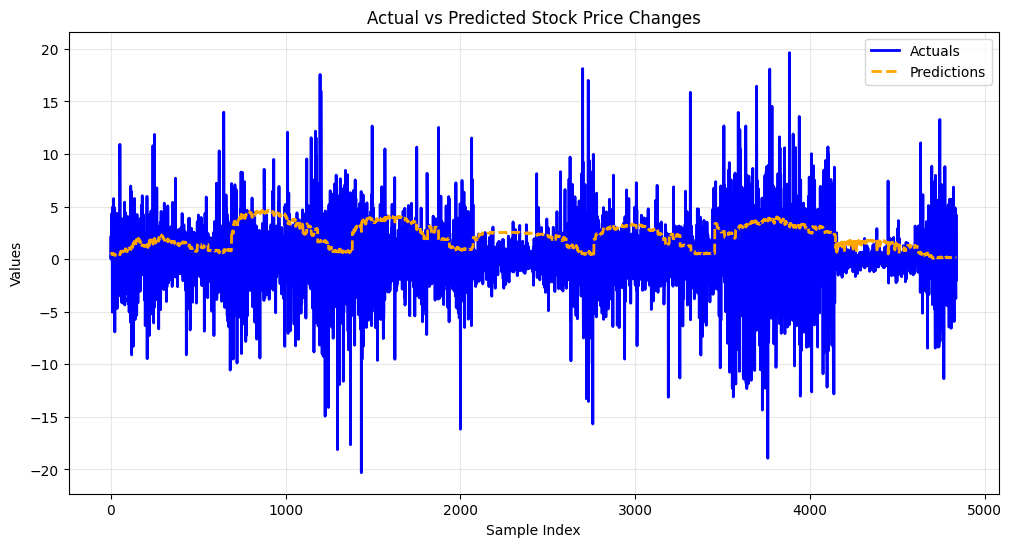

In [131]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals.numpy(), label="Actuals", color="blue", linewidth=2)
plt.plot(predictions.numpy(), label="Predictions", color="orange", linestyle="--", linewidth=2)
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Actual vs Predicted Stock Price Changes")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


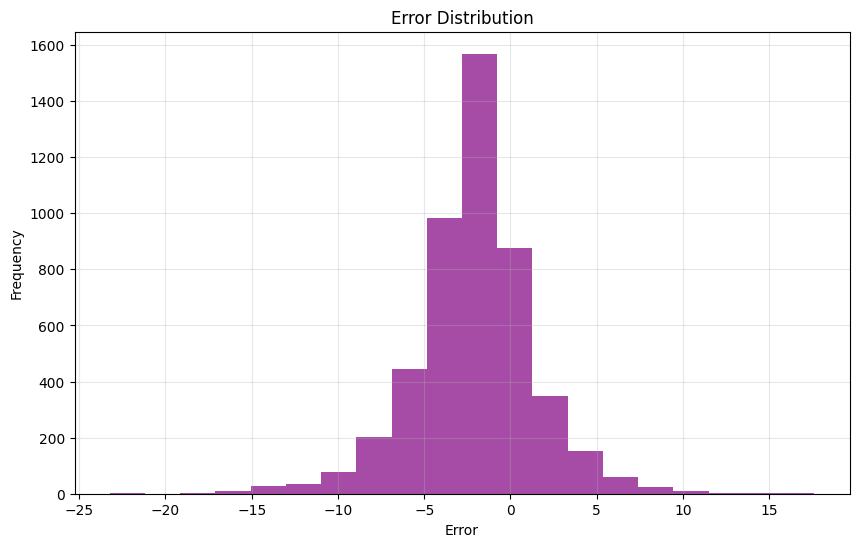

In [132]:
# Calculate errors
errors = actuals.numpy() - predictions.numpy()

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, color="purple", alpha=0.7)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.grid(alpha=0.3)
plt.show()


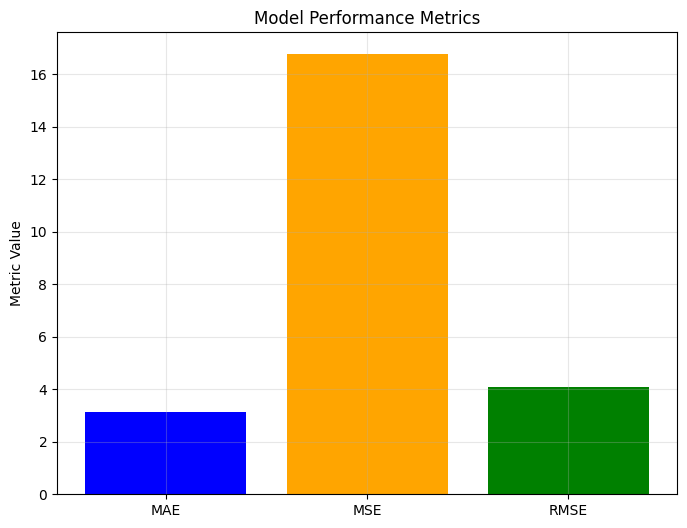

In [133]:
# Example metrics
metrics = {"MAE": mae.item(), "MSE": (errors**2).mean(), "RMSE": (errors**2).mean()**0.5}

# Plot metrics summary
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=["blue", "orange", "green"])
plt.ylabel("Metric Value")
plt.title("Model Performance Metrics")
plt.grid(alpha=0.3)
plt.show()


In [134]:
#Save Model 💾
torch.save(tft.state_dict(), "tft_model.pth")

## Testing (doesn't work)

In [197]:
# Data Prep
required_columns = ['Date', 'Ticker', 'Target_1day', 'Open', 'High', 'Low', 'Close',
                   'Volume', 'GDP (Billions USD)', 'Unemployment Rate (%)',
                   'positive', 'neutral', 'negative'] + [f"emb_{i}" for i in range(768)]

# Add after required_columns selection
# PCA for FinBERT embeddings (Methodology 2.2)
embedding_cols = [f"emb_{i}" for i in range(768)]
pca = PCA(n_components=17)  # 99% variance explained
df[[f"pca_{i}" for i in range(17)]] = pca.fit_transform(df[embedding_cols])

# Replace embedding columns in TFT config
time_varying_unknown_reals=[
    'Close', 'positive', 'negative', 'neutral'
] + [f"pca_{i}" for i in range(17)]  # Instead of 768D


df = df[required_columns].sort_values(by=['Ticker', 'Date'])

# Create time index
df["time_idx"] = df.groupby("Ticker").cumcount()


In [198]:
# Define TimeSeriesDataSet ⚙️
max_encoder_length = 30  # 30-day lookback window
max_prediction_length = 1  # 1-day prediction

training_cutoff = int(df["time_idx"].max() * 0.8)  # 80-20 time-based split

training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Target_1day",
    group_ids=["Ticker"],
    static_categoricals=["Ticker"],
    time_varying_known_reals=[
        'Open', 'High', 'Low', 'Volume',
        'GDP (Billions USD)', 'Unemployment Rate (%)'
    ],
    time_varying_unknown_reals=[
        'Close', 'positive', 'negative', 'neutral'
    ] + [f"emb_{i}" for i in range(768)],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    target_normalizer=GroupNormalizer(groups=["Ticker"], transformation="softplus"),
)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries.py:1831: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 3 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Ticker': 'AMD'}, {'__group_id__Ticker': 'AMZN'}, {'__group_id__Ticker': 'GOOGL'}]
  warnings.warn(


In [199]:
# Dataloaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [200]:
# Configure TFT Model
tft = TemporalFusionTransformer.from_dataset(
    training,
    hidden_size=64,  # Increased from 32
    lstm_layers=3,
    dropout=0.3,      # Increased regularization
    output_size=7,
    loss=QuantileLoss(quantiles=[0.1, 0.25, 0.5, 0.75, 0.9]),  # Fewer quantiles
    learning_rate=0.01,  # Reduced from 0.03
    optimizer="adamw",
    hidden_continuous_size=32
)


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [203]:
# Train Model
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-tft-{epoch}-{val_loss:.2f}",
    save_top_k=1,
    monitor="val_loss"
)

# Update Trainer configuration
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=15),
        LearningRateMonitor(),
        ModelCheckpoint(
            dirpath="checkpoints",
            filename="best-tft-{epoch}-{val_loss:.2f}",
            save_top_k=3,
            monitor="val_loss",
            mode="min",
            auto_insert_metric_name=True
        )
    ],
    enable_progress_bar=True,
    enable_model_summary=True
)



INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [204]:
# Ensure no NaNs in target
assert df["Target_1day"].isna().sum() == 0, "NaN targets present"

# Verify temporal ordering
assert df.groupby("Ticker")["Date"].apply(lambda x: x.is_monotonic_increasing).all()


### Running will take a while

In [205]:
# Evaluate Model
predictions = tft.predict(val_dataloader)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

# Check MAE
mae = (actuals - predictions).abs().mean()
print(f"MAE: {mae:.2f}")

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation m

MAE: 4.93


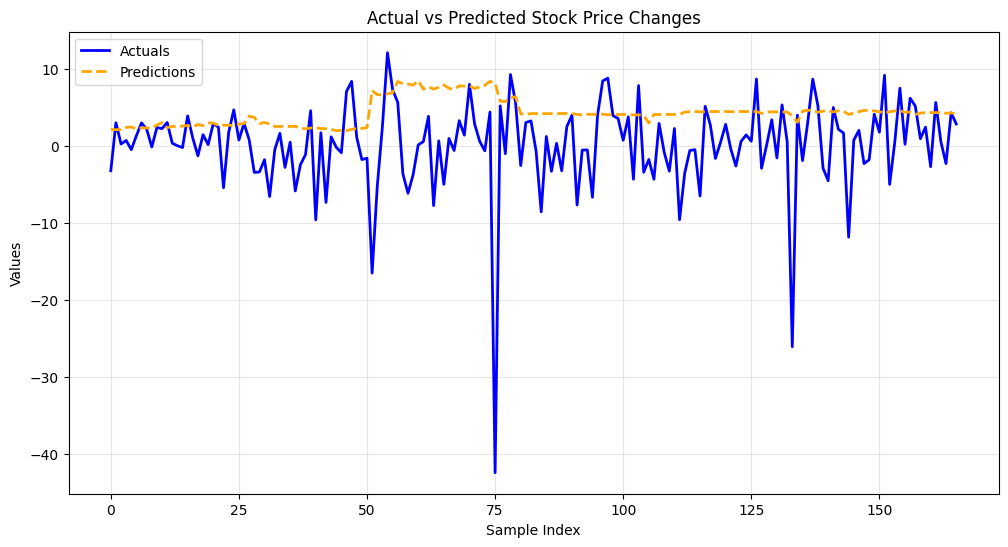

In [207]:
plt.figure(figsize=(12, 6))
plt.plot(actuals.numpy(), label="Actuals", color="blue", linewidth=2)
plt.plot(predictions.numpy(), label="Predictions", color="orange", linestyle="--", linewidth=2)
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Actual vs Predicted Stock Price Changes")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


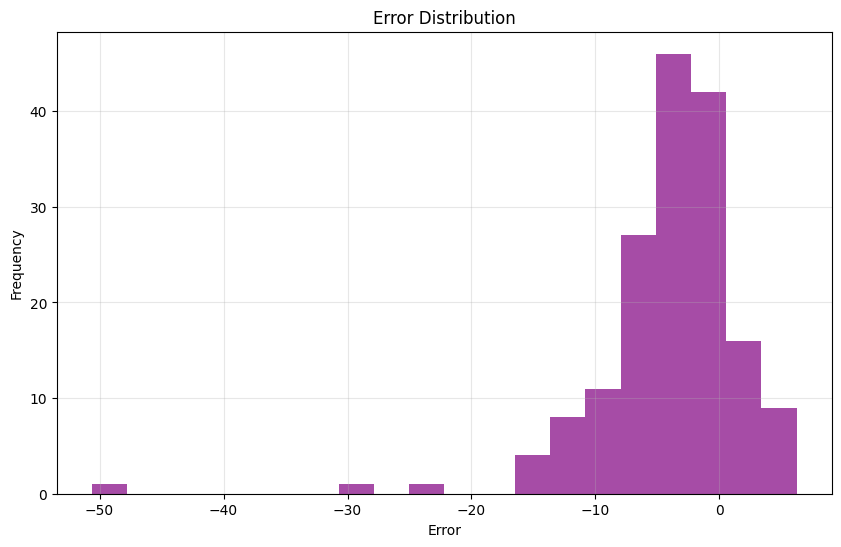

In [208]:
errors = actuals.numpy() - predictions.numpy()

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, color="purple", alpha=0.7)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.grid(alpha=0.3)
plt.show()


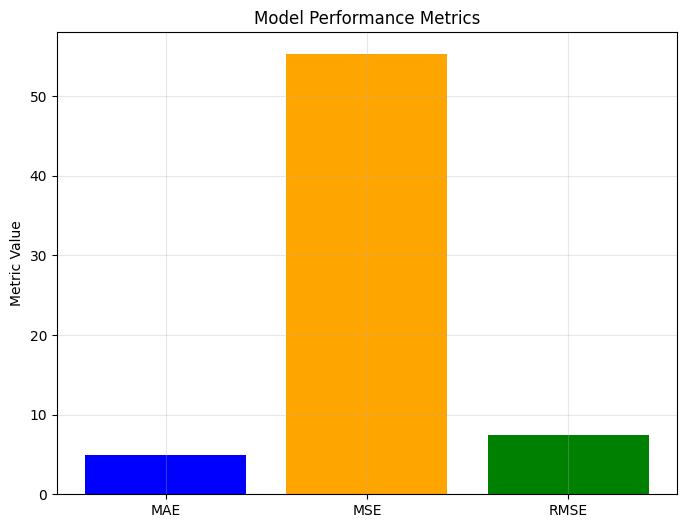

In [209]:
metrics = {
    "MAE": mae.item(),
    "MSE": (errors**2).mean(),
    "RMSE": (errors**2).mean()**0.5
}

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=["blue", "orange", "green"])
plt.ylabel("Metric Value")
plt.title("Model Performance Metrics")
plt.grid(alpha=0.3)
plt.show()


NameError: name 'best_model' is not defined